
# Project with StackOverflow posts

In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse as sp_sparse
from numpy.random import rand

In [5]:
from ast import literal_eval

data_dir = "../nlp_datasets/SE_dataset/"

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [9]:
train = read_data(data_dir+'train.tsv')
validation = read_data(data_dir+'validation.tsv')
test = pd.read_csv(data_dir+'test.tsv', sep='\t') # test doesn't have any tags

train.head(3)

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]


In [10]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

print ('training shape:', X_train.shape, 'validation shape:', X_val.shape, 'test shape:', X_test.shape)

training shape: (100000,) validation shape: (30000,) test shape: (20000,)


## Preparing the data

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ',text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    return text

In [13]:
# test above function
examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
            "How to free c++ memory vector<int> * arr?"]
answers = ["sql server equivalent excels choose function",
           "free c++ memory vectorint arr"]
for i in range(2):
    text = examples[i]
    ans = text_prepare(text)
    ans_correct = answers[i]
    print (i)
    print ('\n answer \t \t :', ans,
           '\n correct answer \t :', ans_correct,
           '\n both are equal \t :', ans==ans_correct)

0

 answer 	 	 : sql server equivalent excels choose function 
 correct answer 	 : sql server equivalent excels choose function 
 both are equal 	 : True
1

 answer 	 	 : free c++ memory vectorint arr 
 correct answer 	 : free c++ memory vectorint arr 
 both are equal 	 : True


In [14]:
# Prepare your data from train, test and validation set
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [15]:
print ( X_train[:2])
print ( X_test[:2])
print ( X_val[:2])


['draw stacked dotplot r', 'mysql select records datetime field less specified value']
['warning mysql_query expects parameter 2 resource object given', 'get click coordinates input typeimage via javascript']
['odbc_exec always fail', 'access base classes variable within child class']


In [16]:
y_train[:2]

array([list(['r']), list(['php', 'mysql'])], dtype=object)

## WordsTagsCount
Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [17]:
from collections import Counter

# Dictionary of all tags from train corpus with their counts.
all_tags = [item for item_list in y_train for item in item_list]
tags_counts = Counter(all_tags)

# Dictionary of all words from train corpus with their counts.
#all_words = [word for line in X_train for word in line.split()]
ALL_WORDS = [word for line in X_train for word in line.split()]
words_counts = Counter(ALL_WORDS)


In [18]:
# The most common items in tags and words
print ( 'The top 3 tags:', tags_counts.most_common(3) )
print ( 'The top 3 words:', words_counts.most_common(3) )

The top 3 tags: [('javascript', 19078), ('c#', 19077), ('java', 18661)]
The top 3 words: [('using', 8278), ('php', 5614), ('java', 5501)]


In [19]:
# get a sorted dictionary
tags_counts_sorted  =  sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)
words_counts_sorted = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

most_common_tags  = tags_counts_sorted[:3]
most_common_words = words_counts_sorted[:3]

print ('most_common_tags',most_common_tags)
print ('most_common_words',most_common_words)

most_common_tags [('javascript', 19078), ('c#', 19077), ('java', 18661)]
most_common_words [('using', 8278), ('php', 5614), ('java', 5501)]


In [20]:
DICT_SIZE = 1000
VOCAB = words_counts.most_common(DICT_SIZE)  # already sorted
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(VOCAB) }
#VOCAB is already sorted hence we don't need to do the following.
#WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate( sorted(VOCAB, key=lambda x: x[1], reverse=True) ) }

INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()}

#print (WORDS_TO_INDEX)
#print (INDEX_TO_WORDS)

In [21]:
def my_bag_of_words(text, words_to_index, dict_size):
    result_vec = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vec[words_to_index[word]] +=1
    return result_vec
        

In [22]:
# test my bag of words
mytext = ['hi how are you']
words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3} # these are the most common words already found
ans = [1, 1, 0, 1]

for i, text in enumerate(mytext):
    vec = my_bag_of_words(text, words_to_index, 4)
    print ('obtained vector:', vec)
    print ('correct ansswer:', ans)
    print ( 'The two are equal (T/F):',(vec==ans).any() )
    
    

obtained vector: [1. 1. 0. 1.]
correct ansswer: [1, 1, 0, 1]
The two are equal (T/F): True


In [25]:
X_train_mybag = sp_sparse.vstack([ sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)


X_train shape  (100000, 1000)
X_val shape  (30000, 1000)
X_test shape  (20000, 1000)


## Bag Of Words

For the 11th row in X_train_mybag find how many non-zero elements it has. In this task the answer (variable non_zero_elements_count) should be a number, e.g. 20.



In [26]:
row = X_train_mybag[10].toarray()[0]

non_zero_elements_count = np.sum([1 for item in row if item != 0])
print (non_zero_elements_count)

4


## TF-IDF
Convert a collection of raw documents to a matrix of TF-IDF features.

    Implement function tfidf_features using class TfidfVectorizer from scikit-learn. Use train corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary.
    
    First use TfidfVectorizer without token_pattern and see if you have 'c+' in tfidf_vocab if not then use '(\S+)' regexp as a token_pattern in the constructor of the vectorizer.


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    # max_df and min_df is to filter out too frequent and too rare words
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 max_df=0.9, min_df=5,
                                 token_pattern='(\S+)' )
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return (X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_ )

In [28]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}


In [29]:
tfidf_vocab['c#']  

1879

## MultiLabel Classifier

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

In [31]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [32]:
y_val

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [34]:
def train_classifier(X_train, y_train):
    model = OneVsRestClassifier(LogisticRegression(penalty='l2', C=1.0, max_iter=500))
    model.fit(X_train, y_train)
    return model


In [35]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [36]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [37]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score   #  extra arguement 'average' is required for multiclass/multilabel targets.
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [39]:
def print_evaluation_scores(y_val, predicted):
    print ("Accracy={}".format(accuracy_score(y_val, predicted)), 
        "F1_macro={}".format(f1_score(y_val, predicted, average='macro')),
        "F1_micro={}".format(f1_score(y_val, predicted, average='micro')),
        "F1_wted={}".format(f1_score(y_val, predicted, average='weighted')),
        "Precsion_macro={}".format(average_precision_score(y_val, predicted, average='macro')),
        "Precsion_micro={}".format(average_precision_score(y_val, predicted, average='micro')),
        "Precsion_wted={}".format(average_precision_score(y_val, predicted, average='weighted')))

In [40]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)


Bag-of-words
Accracy=0.30733333333333335 F1_macro=0.48042789607695546 F1_micro=0.6225785774040394 F1_wted=0.603181533862139 Precsion_macro=0.3235746811091482 Precsion_micro=0.42836779433666106 Precsion_wted=0.4627357127118158
Tfidf
Accracy=0.3339 F1_macro=0.4454765332377671 F1_micro=0.6417184899710957 F1_wted=0.614248024164715 Precsion_macro=0.3018168343817219 Precsion_micro=0.4568968080771187 Precsion_wted=0.48500349929335657


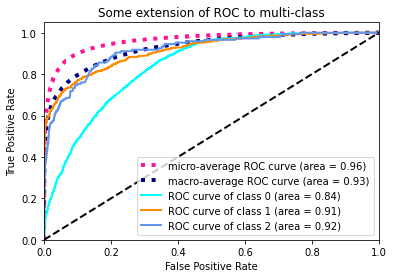

In [41]:
#from utility_metrics import roc_auc
#from utils.wk1_utility_metrics import roc_auc
from utils_metrics import roc_auc
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)


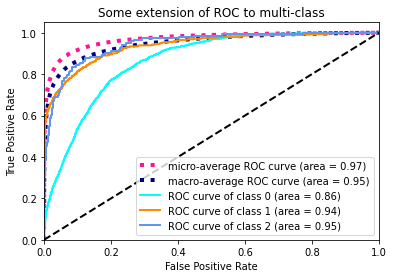

In [42]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)


## MultilabelClassification

Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use F1-score weighted as an evaluation metric. Our recommendation:

compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
for the chosen one, try L1 and L2-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).
You also could try other improvements of the preprocessing / model, if you want.

In [43]:
######### YOUR CODE HERE #############
test_predictions = classifier_tfidf.predict(X_test_tfidf) 
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
#grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

In [44]:
print (test_predictions_for_submission[:100] )

0	php
1	javascript,jquery
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java
8	python
9	h


## Most Important Features

In [45]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    estimator = classifier.estimators_[tags_classes.index(tag)]
    coff = estimator.coef_[0]
    coff_idx = list(enumerate(coff))
    top_pos_words_idx = [idx for idx, wt in sorted(coff_idx, key=lambda x: x[1], reverse=True)[:5]]
    top_neg_words_idx = [idx for idx, wt in sorted(coff_idx, key=lambda x: x[1], reverse=False)[:5]]
    top_positive_words = [index_to_words[idx] for idx in top_pos_words_idx] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[idx] for idx in top_neg_words_idx] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [46]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)


Tag:	c
Top positive words:	c, malloc, scanf, printf, gcc
Top negative words:	java, php, python, javascript, c#

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	linux, ubuntu, c, address, signal
Top negative words:	javascript, c#, jquery, array, method

